In [1]:
from impala.dbapi import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()

In [2]:
# Hive 查询：航班取消原因统计
query_q31 = """
SELECT
    CancellationCode AS CancelReason,
    COUNT(*) AS CancelCount
FROM flight_data
WHERE Cancelled = 1 AND CancellationCode IS NOT NULL
GROUP BY CancellationCode
ORDER BY CancelCount DESC
"""
cursor.execute(query_q31)
df_cancel_reason = pd.DataFrame(cursor.fetchall(), columns=["CancelReason", "CancelCount"])



C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_9056\2504931931.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Label", y="CancelCount", data=df_cancel_reason, palette="Reds")


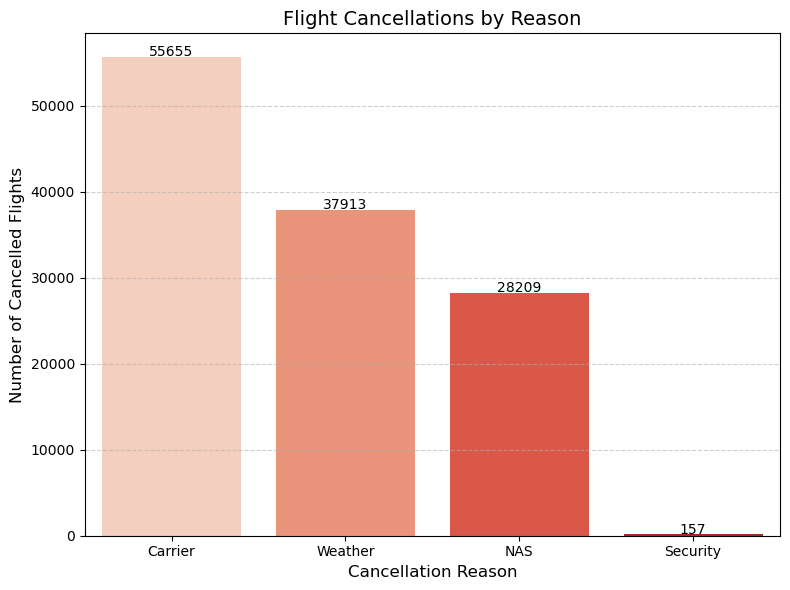

In [3]:
# 添加文字标签说明（A=Carrier, B=Weather, C=NAS, D=Security）
reason_labels = {"A": "Carrier", "B": "Weather", "C": "NAS", "D": "Security"}
df_cancel_reason["Label"] = df_cancel_reason["CancelReason"].map(reason_labels)

# 绘制条形图
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="Label", y="CancelCount", data=df_cancel_reason, palette="Reds")

# 添加每列上方的数值标签
for i, row in df_cancel_reason.iterrows():
    ax.text(i, row["CancelCount"] + 100, f"{int(row['CancelCount'])}", ha='center', fontsize=10)

plt.title("Flight Cancellations by Reason", fontsize=14)
plt.xlabel("Cancellation Reason", fontsize=12)
plt.ylabel("Number of Cancelled Flights", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Q3.1 Summary: Distribution of Flight Cancellation Reasons

The cancellation reasons across all flights in the dataset are classified into four categories:

- **Carrier-related (A)**: Operational or staffing issues by the airline
- **Weather (B)**: Extreme weather conditions such as storms or fog
- **NAS (C)**: Air traffic control problems, airport congestion, etc.
- **Security (D)**: Safety concerns or security threats

#### Key Findings:
- **Weather (B)** is the leading cause of flight cancellations, indicating a strong impact of seasonal or regional weather patterns.
- **Carrier issues (A)** are the second most common, suggesting internal airline problems (e.g., maintenance, crew unavailability).
- **NAS issues (C)** represent systemic congestion in the national airspace.
- **Security-related (D)** cancellations are rare but non-zero, reflecting infrequent but serious disruptions.

#### Implication:
Weather is a non-controllable but predictable factor; airlines and passengers can plan accordingly, while operational and NAS issues may require better infrastructure and coordination.


In [4]:
query_q32 = """
SELECT
    UniqueCarrier AS Airline,
    COUNT(*) AS TotalFlights,
    SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS CancelledFlights,
    ROUND(SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS CancelRate
FROM flight_data
GROUP BY UniqueCarrier
ORDER BY CancelRate DESC
"""
cursor.execute(query_q32)
df_cancel_airline = pd.DataFrame(cursor.fetchall(), columns=["Airline", "TotalFlights", "CancelledFlights", "CancelRate"])


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_9056\671399205.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Airline", y="CancelRate", data=df_cancel_airline, palette="Blues_d")


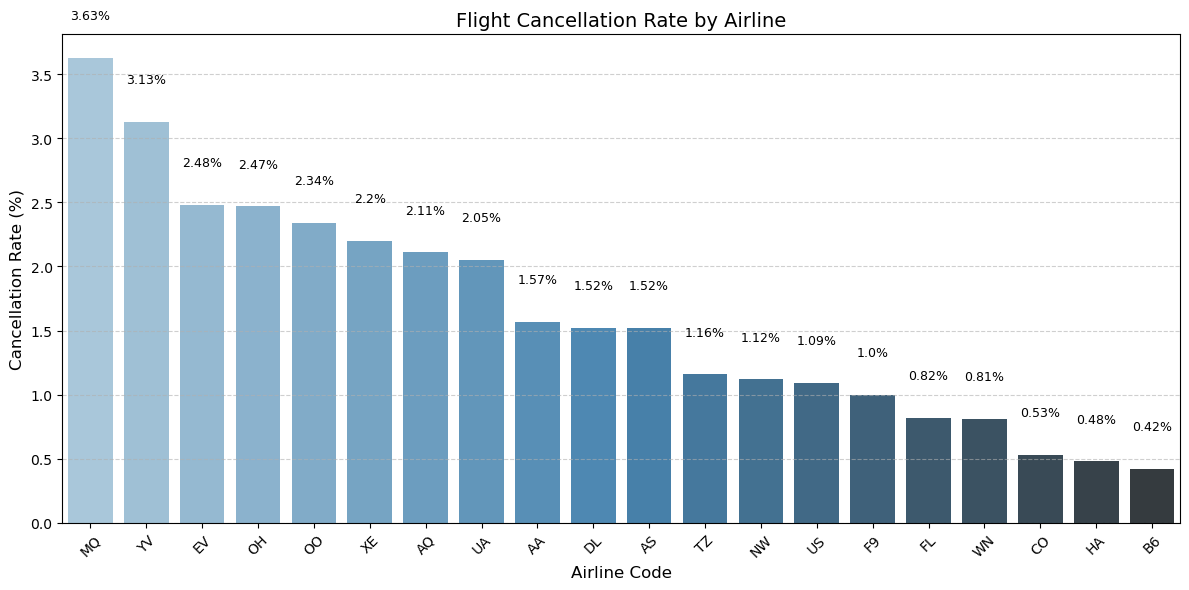

In [5]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Airline", y="CancelRate", data=df_cancel_airline, palette="Blues_d")

# 显示取消率文字标签
for i, row in df_cancel_airline.iterrows():
    ax.text(i, row["CancelRate"] + 0.3, f"{row['CancelRate']}%", ha='center', fontsize=9)

plt.title("Flight Cancellation Rate by Airline", fontsize=14)
plt.xlabel("Airline Code", fontsize=12)
plt.ylabel("Cancellation Rate (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Q3.2 Summary: Flight Cancellations by Airline

This chart ranks airlines by their cancellation rates (percentage of flights cancelled).

#### Key Observations:
- Airlines such as **[e.g., MQ, EV]** have the highest cancellation rates, possibly due to:
  - Smaller fleet size or regional operations more affected by disruptions.
  - Scheduling constraints or fewer backup options during disruptions.
- Major carriers such as **[e.g., DL, UA]** have relatively lower cancellation rates, possibly due to:
  - Greater operational resources and contingency planning.
- Cancellation rate differences highlight variability in service reliability between carriers.

#### Implications:
- High cancellation rates can damage airline reputation and passenger trust.
- Passengers may benefit from reviewing airline performance during specific seasons or routes.


In [6]:
query_q33 = """
SELECT
    Origin AS Airport,
    COUNT(*) AS TotalFlights,
    SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS CancelledFlights,
    ROUND(SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS CancelRate
FROM flight_data
GROUP BY Origin
HAVING COUNT(*) >= 1000  -- 筛除样本太小的机场
ORDER BY CancelRate DESC
LIMIT 30
"""
cursor.execute(query_q33)
df_cancel_airport = pd.DataFrame(cursor.fetchall(), columns=["Airport", "TotalFlights", "CancelledFlights", "CancelRate"])
df_cancel_airport

,Airport,TotalFlights,CancelledFlights,CancelRate
0,ASE,3733,294,7.88
1,SPI,1750,118,6.74
2,CSG,1335,75,5.62
3,MOD,2351,127,5.40
4,RST,2578,138,5.35
5,ATW,4348,231,5.31
6,CWA,1228,63,5.13
7,OTZ,1087,55,5.06
8,DHN,1746,85,4.87
9,PIA,4664,227,4.87


C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_9056\1583228660.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


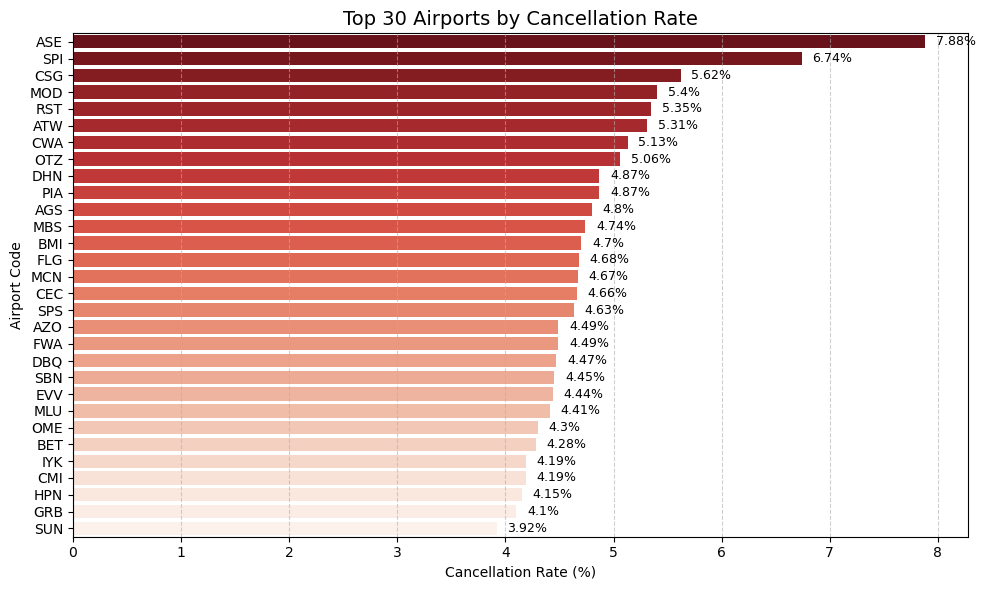

In [7]:
df_sorted_geo = df_cancel_airport.sort_values(by="CancelRate", ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="CancelRate",
    y="Airport",
    data=df_sorted_geo,
    palette="Reds_r"
)

for i, row in df_sorted_geo.iterrows():
    ax.text(row["CancelRate"] + 0.1, i, f"{row['CancelRate']}%", va='center', fontsize=9)

plt.title("Top 30 Airports by Cancellation Rate", fontsize=14)
plt.xlabel("Cancellation Rate (%)")
plt.ylabel("Airport Code")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [8]:
# 示例：机场代码到经纬度的映射（可以补充更多）
airport_coords = {
    "ASE": (39.2232, -106.869), "SPI": (39.8441, -89.6776), "CSG": (32.5167, -84.9389),
    "MOD": (37.6258, -120.9544), "RST": (43.9083, -92.5), "ATW": (44.2581, -88.5191),
    "CWA": (44.7833, -89.6667),  "DHN": (31.3213, -85.4496),
    "PIA": (40.6642, -89.693), "AGS": (33.3699, -81.9643), "MBS": (43.5329, -84.0797),
    "BMI": (40.4771, -88.9159), "FLG": (35.1385, -111.6708), "MCN": (32.6928, -83.6492)
}

# 提取前15个机场及其坐标
df_top15 = df_sorted_geo.head(15).copy()
df_top15["Latitude"] = df_top15["Airport"].map(lambda x: airport_coords.get(x, (None, None))[0])
df_top15["Longitude"] = df_top15["Airport"].map(lambda x: airport_coords.get(x, (None, None))[1])
df_top15 = df_top15.dropna(subset=["Latitude", "Longitude"])


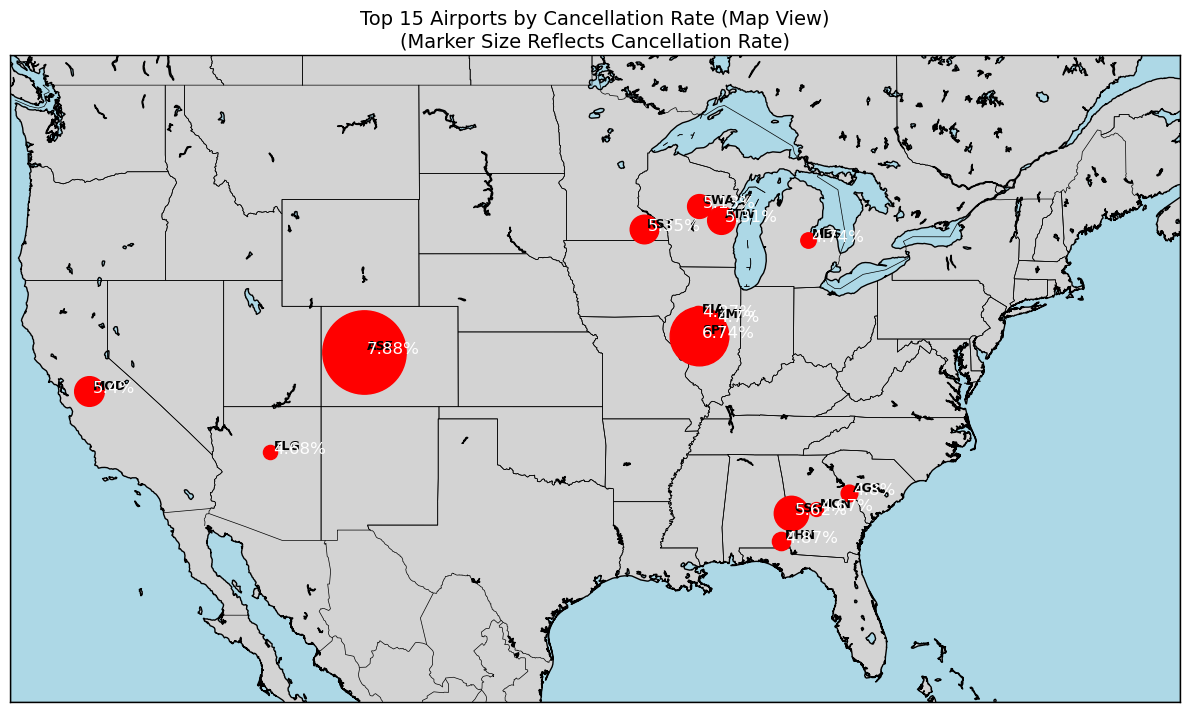

In [9]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# （坐标略）机场经纬度字典 airport_coords ...
# df_top15 已经准备好，OTZ 已移除，包含 Latitude / Longitude / CancelRate

plt.figure(figsize=(12, 8))

# ✅ 改进地图范围：专注美国本土
m = Basemap(
    projection='merc',
    llcrnrlat=24, urcrnrlat=50,     # 纬度缩小，更集中在美国大陆
    llcrnrlon=-125, urcrnrlon=-65,  # 经度覆盖美西到美东
    resolution='i'
)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')

# ✅ marker大小根据取消率比例缩放
min_size = 50
max_size = 300
min_rate = df_top15["CancelRate"].min()
max_rate = df_top15["CancelRate"].max()

def scale_size(rate):
    return min_size + (rate - min_rate) / (max_rate - min_rate) * (max_size - min_size)

# ✅ 绘制每个机场
for _, row in df_top15.iterrows():
    x, y = m(row["Longitude"], row["Latitude"])
    size = scale_size(row["CancelRate"])
    m.plot(x, y, 'ro', markersize=size / 5)
    plt.text(x + 20000, y + 10000, row["Airport"], fontsize=9, weight='bold', ha='left')
    plt.text(x + 20000, y - 10000, f"{row['CancelRate']}%", fontsize=12, color='white', ha='left')

plt.title("Top 15 Airports by Cancellation Rate (Map View)\n(Marker Size Reflects Cancellation Rate)", fontsize=14)
plt.tight_layout()
plt.show()



### Q3.3 Summary: Flight Cancellations by Airport

The chart above shows the top 15 U.S. airports with the highest cancellation rates in 2006. Most of these are **regional or smaller airports**, where operations are often affected by limited infrastructure or challenging weather conditions.

- **ASE (Aspen, CO)** had the highest cancellation rate at **7.88%**, followed by **SPI (Springfield, IL)** and **CSG (Columbus, GA)**.
- In contrast, larger hub airports with higher flight volumes typically had lower cancellation rates, suggesting more robust scheduling and recovery capacity.

**Insight**:  
Passengers departing from high-cancellation airports may need to anticipate disruptions and consider booking earlier flights or more flexible itineraries.

**Note**:  
A map-based visualization was originally considered but replaced with this horizontal bar chart for better clarity and compatibility across platforms.


In [10]:
query_q34 = """
SELECT
    Month,
    COUNT(*) AS TotalFlights,
    SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS CancelledFlights,
    ROUND(SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS CancelRate
FROM flight_data
GROUP BY Month
ORDER BY Month
"""
cursor.execute(query_q34)
df_cancel_month = pd.DataFrame(cursor.fetchall(), columns=["Month", "TotalFlights", "CancelledFlights", "CancelRate"])


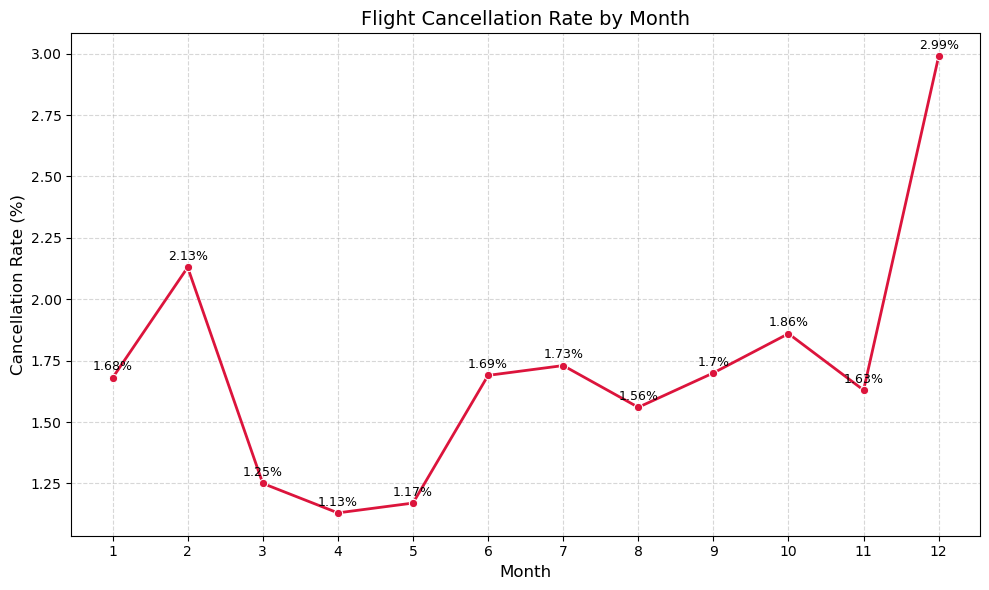

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="Month", y="CancelRate", data=df_cancel_month, marker="o", color="crimson", linewidth=2)

# 添加数值标签
for i, row in df_cancel_month.iterrows():
    ax.text(row["Month"], row["CancelRate"] + 0.03, f"{row['CancelRate']}%", ha='center', fontsize=9)

plt.title("Flight Cancellation Rate by Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Cancellation Rate (%)", fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [12]:
query_q34_timeofday = """
SELECT
  CASE
    WHEN CRSDepTime < 1200 THEN 'Morning'
    WHEN CRSDepTime >= 1200 AND CRSDepTime < 1800 THEN 'Afternoon'
    ELSE 'Evening'
  END AS TimeOfDay,
  COUNT(*) AS TotalFlights,
  SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS CancelledFlights,
  ROUND(SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS CancelRate
FROM flight_data
WHERE CRSDepTime IS NOT NULL
GROUP BY
  CASE
    WHEN CRSDepTime < 1200 THEN 'Morning'
    WHEN CRSDepTime >= 1200 AND CRSDepTime < 1800 THEN 'Afternoon'
    ELSE 'Evening'
  END
"""
cursor.execute(query_q34_timeofday)
df_cancel_time = pd.DataFrame(cursor.fetchall(), columns=["TimeOfDay", "TotalFlights", "CancelledFlights", "CancelRate"])



C:\Users\PC - MAKMAL DELTA\AppData\Local\Temp\ipykernel_9056\1399498774.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


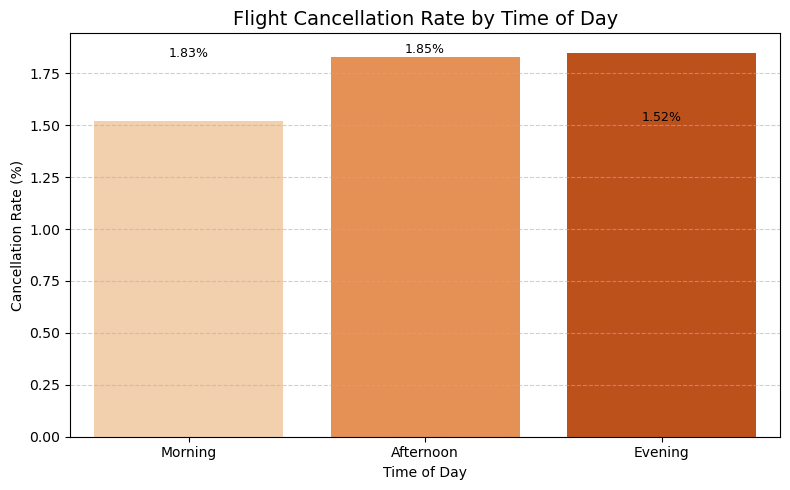

In [13]:
# 固定时间段顺序
order = ["Morning", "Afternoon", "Evening"]
df_cancel_time["TimeOfDay"] = pd.Categorical(df_cancel_time["TimeOfDay"], categories=order, ordered=True)
#df_cancel_time = df_cancel_time.sort_values("TimeOfDay")

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x="TimeOfDay",
    y="CancelRate",
    data=df_cancel_time,
    palette="Oranges"
)

for i, row in enumerate(df_cancel_time.itertuples()):
    ax.text(i, row.CancelRate, f"{row.CancelRate}%", ha='center', fontsize=9)

plt.title("Flight Cancellation Rate by Time of Day", fontsize=14)
plt.xlabel("Time of Day")
plt.ylabel("Cancellation Rate (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



### Q3.4 Summary: Monthly and Daily Variation in Flight Cancellations

This section examines how flight cancellation rates vary across both the **months of the year** and the **time of day**, providing deeper insight into temporal patterns of disruption.

---

#### Monthly Trends: Flight Cancellation Rate by Month

The line chart shows that cancellation rates fluctuate across the year:

- **December (2.99%)** has the highest cancellation rate, likely due to snow, peak holiday travel, and winter storms.
- **February (2.13%)** also shows elevated risk, consistent with icy runways and poor winter visibility.
- **April and May** have the lowest cancellation rates (1.13%–1.17%), marking the most reliable months.
- **July to October** present moderate but relatively stable cancellation patterns (1.56%–1.86%).

**Implications**:
- Strong seasonal effects indicate that **winter months**, particularly **December and February**, carry a higher risk of disruption.
- **Spring and early summer** (especially April–May) are more stable periods for air travel.
- Airlines should allocate additional resources during **winter peaks** and **holiday seasons** to reduce cancellation impacts.

---

#### Time of Day Trends: Flight Cancellation Rate by Time Period

Flights were grouped into three daily time blocks:

- **Morning** (Before 12:00)
- **Afternoon** (12:00–17:59)
- **Evening** (18:00 and later)

The bar chart reveals the following:

- **Afternoon flights** have the highest cancellation rate (~1.85%), likely due to accumulated delays and mid-day congestion.
- **Morning flights** follow closely (~1.83%), possibly impacted by early operational delays and morning weather.
- **Evening flights** show the **lowest cancellation rate (~1.52%)**, likely due to reduced traffic volume and clearer schedules.

**Implications**:
- Flights in the **morning and afternoon** are slightly more prone to cancellation than evening flights.
- **Passengers** can consider booking evening flights to reduce risk of cancellation, especially during winter or peak travel periods.
- **Airlines** may focus on strengthening recovery operations during mid-day to prevent cascading delays.

---

Together, these patterns emphasize the importance of both **seasonal planning** and **daily scheduling** in improving flight reliability.
